In [163]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

startDate = '20200326'
endDate = '20200330'

readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    print(data.columns)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')
    
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

targetStock = rawOrderLog['secid'].unique()
targetStock = np.array([int(str(i)[1:]) for i in targetStock])
targetStockSZ = sorted(targetStock[targetStock < 600000])
targetStockSH = sorted(targetStock[targetStock >= 600000])

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog['colo_broker'] = rawOrderLog['colo'] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['colo_account'] = rawOrderLog['colo'] + '_' + rawOrderLog['accCode'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
orderLog = rawOrderLog.copy()

### make sure no order has shares > 80w or notional > 800w
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']

### make sure same direction in same colo_broker
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection'].nunique() == 1).all() == True)

## make sure each account, secid, vai only has one insertion
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    a = a[a>1].reset_index()
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()
placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]

### make sure there is no unexpected updateType 
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4)]), 0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3)]), 1,
                     np.where(checkLog['updateType'] == (0, 2, 1, 3), 2,
                     np.where(checkLog['updateType'].isin([(0, 3)]), 3,
                     np.where(checkLog['updateType'].isin([(0, ), (0, 2), (0, 2, 1)]), 4, 5)))))

orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### check status==0 got all traded
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check status==1 got partial traded
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check if any cancellation within 1 sec
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["maxFilled"] = orderLog.groupby("order")["absOrderSizeCumFilled"].transform("max")
orderLog["totalNtl"] = orderLog.groupby("order")["tradeNtl"].transform("sum")
test = orderLog[(orderLog["exchange"] == "SSE") & (orderLog["isMsg"] == 1)]
test1 = orderLog[(orderLog["exchange"] == "SSE") & (orderLog["isMsg"] != 1)]

Index(['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'ars',
       'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
       'absOrderSizeCumFilled', 'orderPrice', 'tradePrice', 'date', 'accCode',
       'mse', 'colo', 'orderSysId', 'tradeId', 'sdd', 'aaa', 'ApplSeqNum'],
      dtype='object')
Index(['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'ars',
       'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
       'absOrderSizeCumFilled', 'orderPrice', 'tradePrice', 'date', 'accCode',
       'mse', 'colo', 'orderSysId', 'tradeId', 'sdd', 'aaa', 'ApplSeqNum'],
      dtype='object')
Index(['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'ars',
       'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
       'absOrderSizeCumFilled', 'orderPrice', 'tradePrice', 'date', 'accCode',
       'mse', 'colo', 'orderSysId', 'tradeId', 'sdd', 'aaa', 'ApplSeqNum'],
      dtype='object')


### 1. The filled percentage of orders

In [161]:
test["perc"] = test["maxFilled"] / test["absOrderSize"]
perc = test.groupby(['order'])['perc'].first().reset_index()
perc["perc"].describe([0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2])
perc['fill status'] = np.where(perc['perc'] == 0, 'no fill',
                                   np.where(perc['perc'] < 1, 'partial fill', "full fill"))
re = perc.groupby("fill status")["perc"].count().reindex(['no fill', 'partial fill', 'full fill']).reset_index()
re = re.rename(columns={"perc": "count"})
re["perc"] = re["count"]/re["count"].sum()
test1["perc"] = test1["maxFilled"] / test1["absOrderSize"]
perc1 = test1.groupby(['order'])['perc'].first().reset_index()
perc1["perc"].describe([0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2])
perc1['fill status'] = np.where(perc1['perc'] == 0, 'no fill',
                                   np.where(perc1['perc'] < 1, 'partial fill', "full fill"))
re1 = perc1.groupby("fill status")["perc"].count().reindex(['no fill', 'partial fill', 'full fill']).reset_index()
re1 = re1.rename(columns={"perc": "count"})
re1["perc"] = re1["count"]/re1["count"].sum()
fp = pd.merge(re, re1, on="fill status")
fp = fp.rename(columns={"count_x": "count_mbd", "perc_x":"perc_mbd", "count_y":"count_snapshot", "perc_y":"perc_snapshot"})
fp["perc_diff"] = fp["perc_mbd"] - fp["perc_snapshot"]
fp = fp[["fill status", "count_mbd", "count_snapshot", "perc_mbd", "perc_snapshot", "perc_diff"]]
for col in ["perc_mbd", "perc_snapshot", "perc_diff"]:
    fp[col] = fp[col].fillna(0)
    fp[col] = fp[col].apply(lambda x: '%.1f%%'%(x*100))
fp

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,fill status,count_mbd,count_snapshot,perc_mbd,perc_snapshot,perc_diff
0,no fill,171,3188,12.1%,16.2%,-4.1%
1,partial fill,117,1495,8.3%,7.6%,0.7%
2,full fill,1130,15036,79.7%,76.3%,3.4%


### 2. Trade price order price deviation

In [129]:
kk = test[test["updateType"] == 4]
kk["diff"] = np.where(kk["orderDirection"] == -1, kk["tradePrice"] - kk["orderPrice"], kk["orderPrice"] - kk["tradePrice"])
kk["diff"] = kk["diff"].round(2)
re1 = kk.groupby("diff")["order"].count().reset_index()
re2 = kk.groupby("diff")["absFilledThisUpdate"].sum().reset_index()
re3 = kk.groupby(["order", "diff"])["maxFilled"].first().reset_index().groupby("diff")["maxFilled"].sum().reset_index()
re = pd.merge(re1, re2, on="diff")
re = pd.merge(re, re3, on="diff")
re = re.rename(columns = {"order": "tick count", "absFilledThisUpdate":"thisTradeSize", "maxFilled": "totalTradeSize"})
re["perc"] = re["thisTradeSize"] / re["totalTradeSize"]
re["perc1"] = re["thisTradeSize"] / re["thisTradeSize"].sum()
re["money_saved"] = re["diff"] * re["thisTradeSize"]
# display(re)
display(re["money_saved"].sum() / (test[test["updateType"] == 4]["tradeNtl"].sum() + re["money_saved"].sum()))
kk1 = test1[test1["updateType"] == 4]
kk1["diff"] = np.where(kk1["orderDirection"] == -1, kk1["tradePrice"] - kk1["orderPrice"], kk1["orderPrice"] - kk1["tradePrice"])
kk1["diff"] = kk1["diff"].round(2)
ree1 = kk1.groupby("diff")["order"].count().reset_index()
ree2 = kk1.groupby("diff")["absFilledThisUpdate"].sum().reset_index()
ree3 = kk1.groupby(["order", "diff"])["maxFilled"].first().reset_index().groupby("diff")["maxFilled"].sum().reset_index()
ree = pd.merge(ree1, ree2, on="diff")
ree = pd.merge(ree, ree3, on="diff")
ree = ree.rename(columns = {"order": "tick count", "absFilledThisUpdate":"thisTradeSize", "maxFilled": "totalTradeSize"})
ree["perc"] = ree["thisTradeSize"] / ree["totalTradeSize"]
ree["perc1"] = ree["thisTradeSize"] / ree["thisTradeSize"].sum()
ree["money_saved"] = ree["diff"] * ree["thisTradeSize"]
# display(ree)
display(ree["money_saved"].sum() / (test1[test1["updateType"] == 4]["tradeNtl"].sum() + ree["money_saved"].sum()))
tp = pd.merge(re[["diff", "tick count", "thisTradeSize", "perc1"]], ree[["diff", "tick count", "thisTradeSize", "perc1"]], on="diff")
tp = tp.rename(columns={"tick count_x": "count_mbd","tick count_y": "count_snapshot", "thisTradeSize_x": "tradesize_mbd","thisTradeSize_y": "tradesize_snapshot",
                       "perc1_x":"perc_mbd", "perc1_y": "perc_snapshot"})
tp = tp[["diff", "count_mbd", "count_snapshot", "tradesize_mbd", "tradesize_snapshot", "perc_mbd", "perc_snapshot"]]
for col in ["perc_mbd", "perc_snapshot"]:
    tp[col] = tp[col].fillna(0)
    tp[col] = tp[col].apply(lambda x: '%.2f%%'%(x*100))
tp

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2.252678810339178e-05

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7.591214452626539e-05

,diff,count_mbd,count_snapshot,tradesize_mbd,tradesize_snapshot,perc_mbd,perc_snapshot
0,0.00,3761,46784,12263380,113368886,98.85%,93.91%
1,0.01,71,3079,122500,5267893,0.99%,4.36%
2,0.02,25,766,13256,1068808,0.11%,0.89%
3,0.03,1,415,500,570696,0.00%,0.47%
4,0.04,1,121,100,199442,0.00%,0.17%
5,0.05,2,65,4000,59963,0.03%,0.05%
6,0.14,3,6,1800,19596,0.01%,0.02%


### 3. Time takes to fulfill the order

count       1130
mean       73270
std       129052
min          280
25%         7263
50%        25620
75%        86874
max      1877720
Name: totalNtl, dtype: int32

2508472

count      15036
mean       92811
std       286354
min           49
25%         8360
50%        23423
75%        76350
max      8004192
Name: totalNtl, dtype: int32

5457868

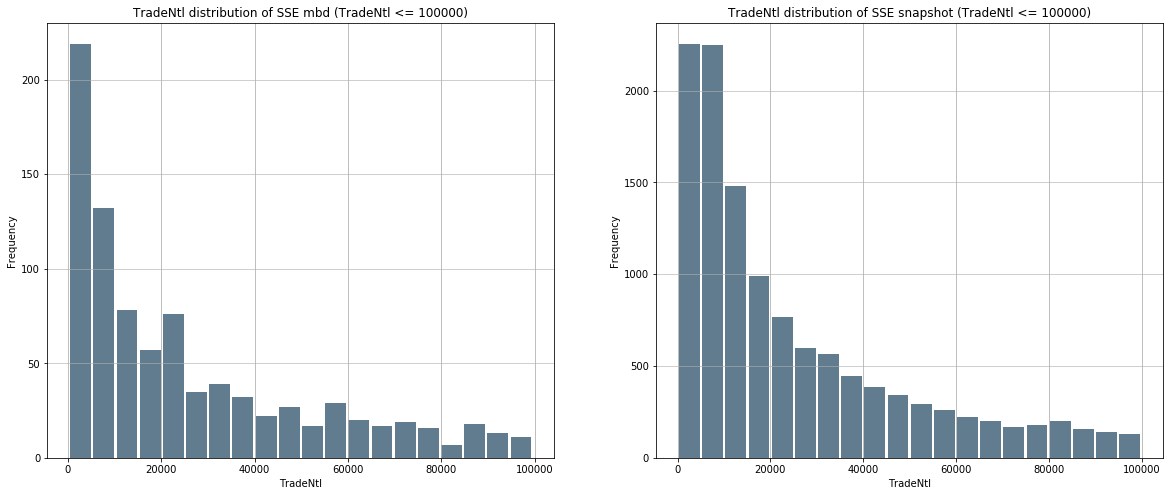

In [218]:
ff = test[(test["updateType"].isin([0, 4])) & (test["maxFilled"] == test["absOrderSize"])]
display(ff[ff["updateType"] == 0]["totalNtl"].describe().astype(int))
ff = ff.sort_values(by=["order", "clockAtArrival"])
ff["caalast"] = ff.groupby("order")["clockAtArrival"].transform("last")
ff = ff[ff["updateType"] == 0]
ff["interval"] = ff["caalast"] - ff["clockAtArrival"]
display(int((ff["absOrderSize"] * ff["interval"]).sum()/ff["absOrderSize"].sum()))
ff1 = test1[(test1["updateType"].isin([0, 4])) & (test1["maxFilled"] == test1["absOrderSize"])]
display(ff1[ff1["updateType"] == 0]["totalNtl"].describe().astype(int))
ff1 = ff1.sort_values(by=["order", "clockAtArrival"])
ff1["caalast"] = ff1.groupby("order")["clockAtArrival"].transform("last")
ff1 = ff1[ff1["updateType"] == 0]
ff1["interval"] = ff1["caalast"] - ff1["clockAtArrival"]
display(int((ff1["absOrderSize"] * ff1["interval"]).sum()/ff1["absOrderSize"].sum()))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
ff[ff["updateType"] == 0]["totalNtl"][ff[ff["updateType"] == 0]["totalNtl"] <= 100000].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('TradeNtl distribution of SSE mbd (TradeNtl <= 100000)')
plt.xlabel('TradeNtl')
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 2, 2)
ff1[ff1["updateType"] == 0]["totalNtl"][ff1[ff1["updateType"] == 0]["totalNtl"] <= 100000].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('TradeNtl distribution of SSE snapshot (TradeNtl <= 100000)')
plt.xlabel('TradeNtl')
plt.grid(axis='y', alpha=0.75)

In [173]:
len(test[test["updateType"]==4]["order"].unique())

1247

### 4. immediate fill rate comparison

In [148]:
orderLog["ars"] = orderLog.groupby(['date', 'order'])['ars'].transform('first')
orderLog["sta"] = np.where(orderLog["ars"] == 21, "statwo", "staone")
orderLog['Price'] = orderLog['orderPrice'].apply(lambda x: round(x*100, 0))
orderLog['orderNtl'] = orderLog['Price'] * orderLog['absOrderSize'] / 100
orderLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
orderLog['firstUpdateType'] = orderLog.groupby(['order'])['updateType'].transform('first')
orderLog['firstClock'] = orderLog.groupby(['order'])['clockAtArrival'].transform('first')
orderLog['clockDif'] = orderLog['clockAtArrival'] - orderLog['firstClock']
orderLog['isImmediate'] = np.where(orderLog['secid'] >= 2000000,
                          np.where(orderLog['colo_broker'] == 'zs_62', 
                                   np.where(orderLog['clockDif'] <= 1000000, 1, 0),
                                   np.where(orderLog['colo_broker'] == 'zt_88',
                                           np.where(orderLog['clockDif'] <= 50000, 1, 0),
                                           np.where(orderLog['clockDif'] <= 20000, 1, 0))),
                          np.where(orderLog['clockDif'] <= 1000000, 1, 0))

# groupby (exchange, ars, isMsg):
checkData = orderLog[orderLog['isImmediate'] == 1].reset_index(drop=True)
checkData['exchange'] = np.where(checkData['secid'] >= 2000000, 'SZE', 'SSE')
checkData = checkData[checkData["exchange"] == "SSE"]
checkData['maxFilled'] = checkData.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkData['immedFillNtl'] = checkData['maxFilled'] * checkData['Price'] / 100
checkData = checkData[checkData['updateType'] == 0]

checkData = checkData[checkData["exchange"] == "SSE"]

immedFillData = checkData.groupby(['exchange', 'sta', 'isMsg'])[['orderNtl', 'immedFillNtl']].sum().reset_index()
immedFillData['immedFillPerc'] = immedFillData['immedFillNtl'] / immedFillData['orderNtl']
immedFillData = immedFillData[['exchange', 'sta', 'immedFillPerc', 'isMsg']]


checkData['fillStatus'] = np.where(checkData['maxFilled'] == 0, 0,
                          np.where(checkData['maxFilled'] < checkData['absOrderSize'], 1, 2))
statsData = checkData.groupby(['exchange', 'sta', 'isMsg', 'fillStatus'])['secid'].count().to_frame().reset_index()
statsData.columns = ['exchange', 'sta', 'isMsg', 'fillStatus', 'count']
statsData = statsData.reset_index()
statsData['# of orders'] = statsData.groupby(['exchange','sta'])['count'].transform('sum')
statsData['% of orders'] = statsData.groupby(['sta', 'exchange', "isMsg"])['count'].transform('sum')
statsData['percent'] = statsData['count'] / statsData['% of orders']
statsData['% of orders'] = statsData['% of orders'] / statsData['# of orders']
saveCols = ['sta', 'exchange', 'isMsg', 'percent']
noFillData = statsData[statsData['fillStatus'] == 0][saveCols].reset_index(drop=True)
noFillData = noFillData.rename(columns={'percent': 'no fill'})
partialFillData = statsData[statsData['fillStatus'] == 1][saveCols].reset_index(drop=True)
partialFillData = partialFillData.rename(columns={'percent': 'partial fill'})
fullFillData = statsData[statsData['fillStatus'] == 2][saveCols].reset_index(drop=True)
fullFillData = fullFillData.rename(columns={'percent': 'full fill'})


orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
o1 = orderLog[orderLog["exchange"] == "SSE"]



fillRateData = o1.groupby(['exchange', 'sta', 'secid', 'order', 'isMsg'])[['absOrderSizeCumFilled', 'absOrderSize', 'orderPrice']].max().reset_index()
fillRateData['orderNotional'] = fillRateData['absOrderSize']*fillRateData['orderPrice']
fillRateData['fillNotional'] = fillRateData['absOrderSizeCumFilled']*fillRateData['orderPrice']
fillRateData['totalNotional'] = fillRateData.groupby(['exchange', 'sta', "isMsg"])['orderNotional'].transform('sum')
fillRateData['fillNotional'] = fillRateData.groupby(['exchange', 'sta', "isMsg"])['fillNotional'].transform('sum')
fillRateData['fillPerc'] = fillRateData['fillNotional'] / fillRateData['totalNotional']
fillRateData = fillRateData.groupby(['exchange', 'sta', "isMsg"])['fillPerc'].mean().reset_index()

statsData = statsData.groupby(['exchange', 'sta', 'isMsg', '# of orders'])['% of orders'].first().reset_index()
statsData = pd.merge(statsData, noFillData, how='outer', on=['sta', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, partialFillData, how='outer', on=['sta', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, fullFillData, how='outer', on=['sta', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, fillRateData, how='outer', on=['sta', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, immedFillData, how='outer', on=['sta', 'exchange', 'isMsg'], validate='one_to_one')


# statsData = statsData.groupby(['exchange', '# of orders', 'broker'])[['% of orders', 'full fill', 'partial fill', 'no fill', 'fillPerc', 'immedFillPerc']].first()
statsData['isMsg'] = statsData['isMsg'].astype("int")
statsData = statsData.groupby(['exchange', 'sta', '# of orders','isMsg' ])[['% of orders', 'full fill', 'partial fill', 'no fill', 'fillPerc', 'immedFillPerc']].first()

from IPython.display import display, HTML
for col in ['% of orders', 'no fill', 'partial fill', 'full fill', 'fillPerc', 'immedFillPerc']:
    statsData[col] = statsData[col].fillna(0)
    statsData[col] = statsData[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(statsData.to_html()))

### 5. order return comparison

In [219]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import pickle
from IPython.display import display, HTML
startDate = '20200326'
endDate = '20200330'

readPath = "F:\\orderLog\\result\\90s return\\"
dataPathLs = np.array(glob.glob(readPath + 'OrderLog1_***.csv'))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
df = []

for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data["ars"] = data.groupby(['order'])['ars'].transform('first')
    data["sdd"] = data.groupby(['order'])['sdd'].transform('first')
    data['isMsg'] = np.where(data['updateType'] == 0, np.where(data['mse'] == 100, 1, 0), np.nan)
    data['isMsg'] = data.groupby(['order'])['isMsg'].ffill()
    data["sta"] = np.where(data["ars"] == 21, "statwo", "staone")
    data = data[(data["updateType"] == 4) & (data["exchange"] == "SSE")]
    data = data[data["sdd"] >= 93300000]
    data["indexRet"] = data["close_F90s"]/data["close"] - 1
    data["buyAlpha"] = np.where(data["orderDirection"] == 1, data["buyRet"] - data["indexRet"] * data["beta_60"], np.nan)
    data["sellAlpha"] = np.where(data["orderDirection"] == -1, data["sellRet"] + data["indexRet"] * data["beta_60"], np.nan)
    data["pp"] = (data.groupby("order").cumcount()+1)[lambda x: x <= 1]
    data["buyNum"] = np.where((data["orderDirection"] == 1) & (data["pp"]==1), 1, 0)
    data["sellNum"] = np.where((data["orderDirection"] == -1) & (data["pp"]==1), 1, 0)
    data["accCode"] = data["colo"] + data["accCode"].astype(int).astype("str")
    df += [data]
df = pd.concat(df, sort=False)

df["buyNtl"] = np.where(~df["buyRet"].isnull(), df["tradeNtl"], np.nan)
df["sellNtl"] = np.where(~df["sellRet"].isnull(), df["tradeNtl"], np.nan)
df["sumbuyNtl"] = df.groupby(["exchange", "sta", "isMsg"])["buyNtl"].transform(sum)
df["sumsellNtl"] = df.groupby(["exchange", "sta", "isMsg"])["sellNtl"].transform(sum)
    
df["sumsellRet"] = df["tradeNtl"] * df["sellRet"]
df["sumsellRet"] = df.groupby(["exchange", "sta", "isMsg"])["sumsellRet"].transform(sum)
    
df["sumbuyAlpha"] = df["tradeNtl"] * df["buyAlpha"]
df["sumbuyAlpha"] = df.groupby(["exchange",  "sta", "isMsg"])["sumbuyAlpha"].transform(sum)
    
df["sumsellAlpha"] = df["tradeNtl"] * df["sellAlpha"]
df["sumsellAlpha"] = df.groupby(["exchange",  "sta", "isMsg"])["sumsellAlpha"].transform(sum)
    
df["sumbuyRet"] = df["tradeNtl"] * df["buyRet"]
df["sumbuyRet"] = df.groupby(["exchange", "sta", "isMsg"])["sumbuyRet"].transform(sum)

df["buyRet"] = df["sumbuyRet"] / df["sumbuyNtl"]
df["sellRet"] = df["sumsellRet"] / df["sumsellNtl"]
df["buyAlpha"] = df["sumbuyAlpha"] / df["sumbuyNtl"]
df["sellAlpha"] = df["sumsellAlpha"] / df["sumsellNtl"]
df["buyOrderNum"] = df.groupby(["exchange",  "sta", "isMsg"])["buyNum"].transform(sum)
df["sellOrderNum"] = df.groupby(["exchange", "sta", "isMsg"])["sellNum"].transform(sum)

from IPython.display import display, HTML
for col in ["buyRet", "sellRet", "buyAlpha", "sellAlpha"]:
    df[col] = df[col].apply(lambda x: '%.2f'%(x*10000))
HTML(df.groupby(["exchange", "sta", "isMsg"])["buyOrderNum", "buyRet", "buyAlpha", "sellOrderNum", "sellRet", "sellAlpha"].first().to_html())

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
